In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np

# Load dataset (already in proper multi-column format)
df = pd.read_csv('MBA.csv', header=None)

# Convert rows to lists of items
transactions = df.apply(lambda row: row.dropna().tolist(), axis=1)

# Preprocess items into one-hot encoding
all_items = sorted(set(item.strip() for sublist in transactions for item in sublist))
encoded_vals = []
for trans in transactions:
    row = {item: 0 for item in all_items}
    for item in trans:
        row[item.strip()] = 1
    encoded_vals.append(row)
df_encoded = pd.DataFrame(encoded_vals)

# Generate frequent itemsets and rules
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Extra interestingness metrics
rules['all_confidence'] = rules[['confidence', 'consequent support']].min(axis=1)
rules['cosine'] = rules['support'] / (
    (rules['antecedent support'] * rules['consequent support']) ** 0.5
)
rules['improvement'] = rules['confidence'] - rules['consequent support']
rules['added_value'] = rules['confidence'] - rules['consequent support']
rules['gini_index'] = rules['support'] * (1 - rules['confidence']**2 - (1 - rules['confidence'])**2)
rules['lift_diff'] = rules['lift'] - 1

# KL Divergence (safely)
def safe_kl(confidence, consequent_support):
    if confidence <= 0 or consequent_support <= 0:
        return 0
    return confidence * np.log2(confidence / consequent_support)
rules['kl_divergence'] = rules.apply(lambda row: safe_kl(row['confidence'], row['consequent support']), axis=1)

# Final selected columns
selected_columns = [
    'antecedents', 'consequents',
    'support', 'confidence', 'lift',
    'leverage', 'conviction', 'zhangs_metric',
    'jaccard', 'certainty', 'kulczynski',
    'cosine', 'all_confidence', 'improvement', 'added_value',
    'gini_index', 'lift_diff', 'kl_divergence'
]
rules_selected = rules[selected_columns].sort_values(by='lift', ascending=False)

# Output enriched rules
print("\n🧠 Top Enriched Association Rules:\n")
print(rules_selected.head(10).to_string(index=False))

# Save to CSV
rules_selected.to_csv("enriched_association_rules.csv", index=False)
print("\n📁 Rules saved to 'enriched_association_rules.csv'")


C:\Users\shrin\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



🧠 Top Enriched Association Rules:

               antecedents                consequents  support  confidence     lift  leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski   cosine  all_confidence  improvement  added_value  gini_index  lift_diff  kl_divergence
           (herb & pepper)              (ground beef) 0.015998    0.323450 3.291994  0.011138    1.332860       0.732460 0.121457   0.249734    0.243136 0.229488        0.098254     0.225197     0.225197    0.007002   2.291994       0.555998
             (ground beef)            (herb & pepper) 0.015998    0.162822 3.291994  0.011138    1.135410       0.772094 0.121457   0.119261    0.243136 0.229488        0.049460     0.113362     0.113362    0.004361   2.291994       0.279885
             (ground beef) (spaghetti, mineral water) 0.017064    0.173677 2.907928  0.011196    1.137902       0.727602 0.121097   0.121190    0.229696 0.222760        0.059725     0.113952     0.113952    0.004898   1.907928       0.267

C:\Users\shrin\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


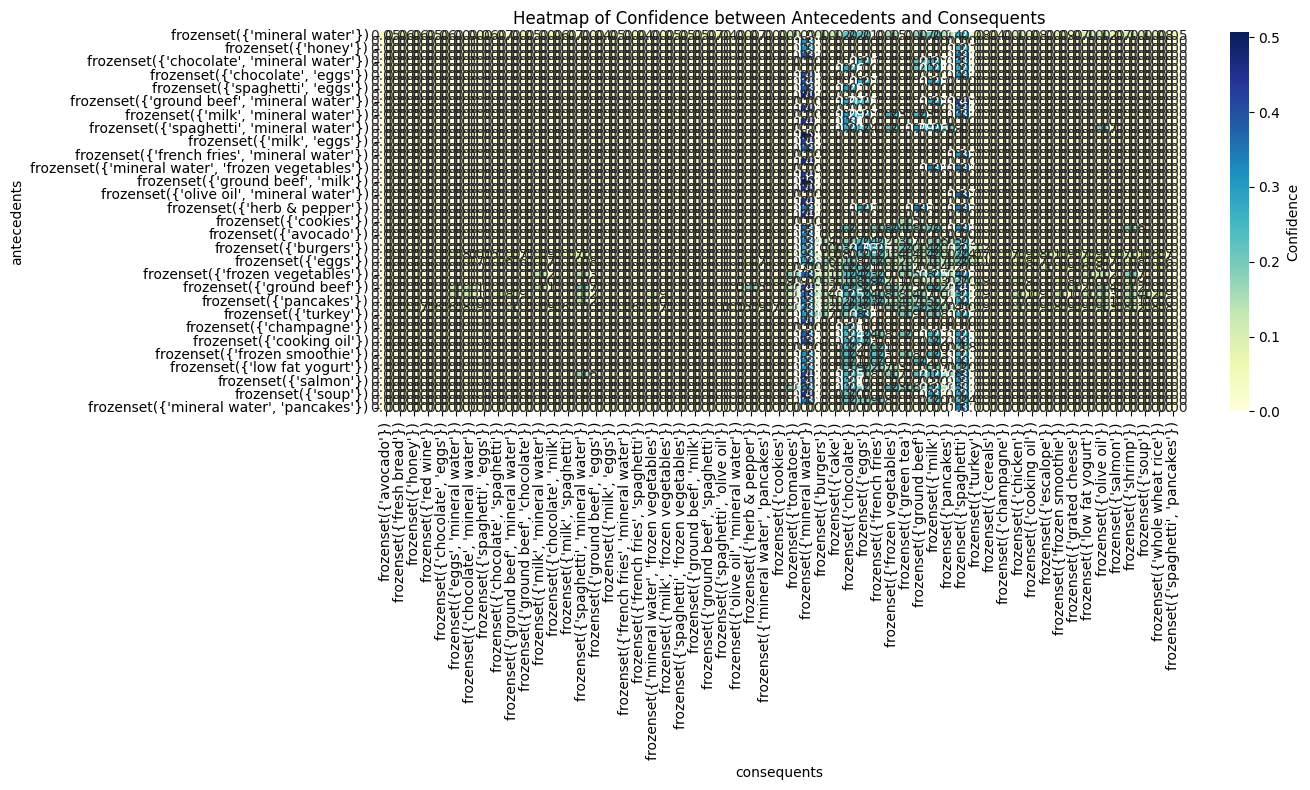

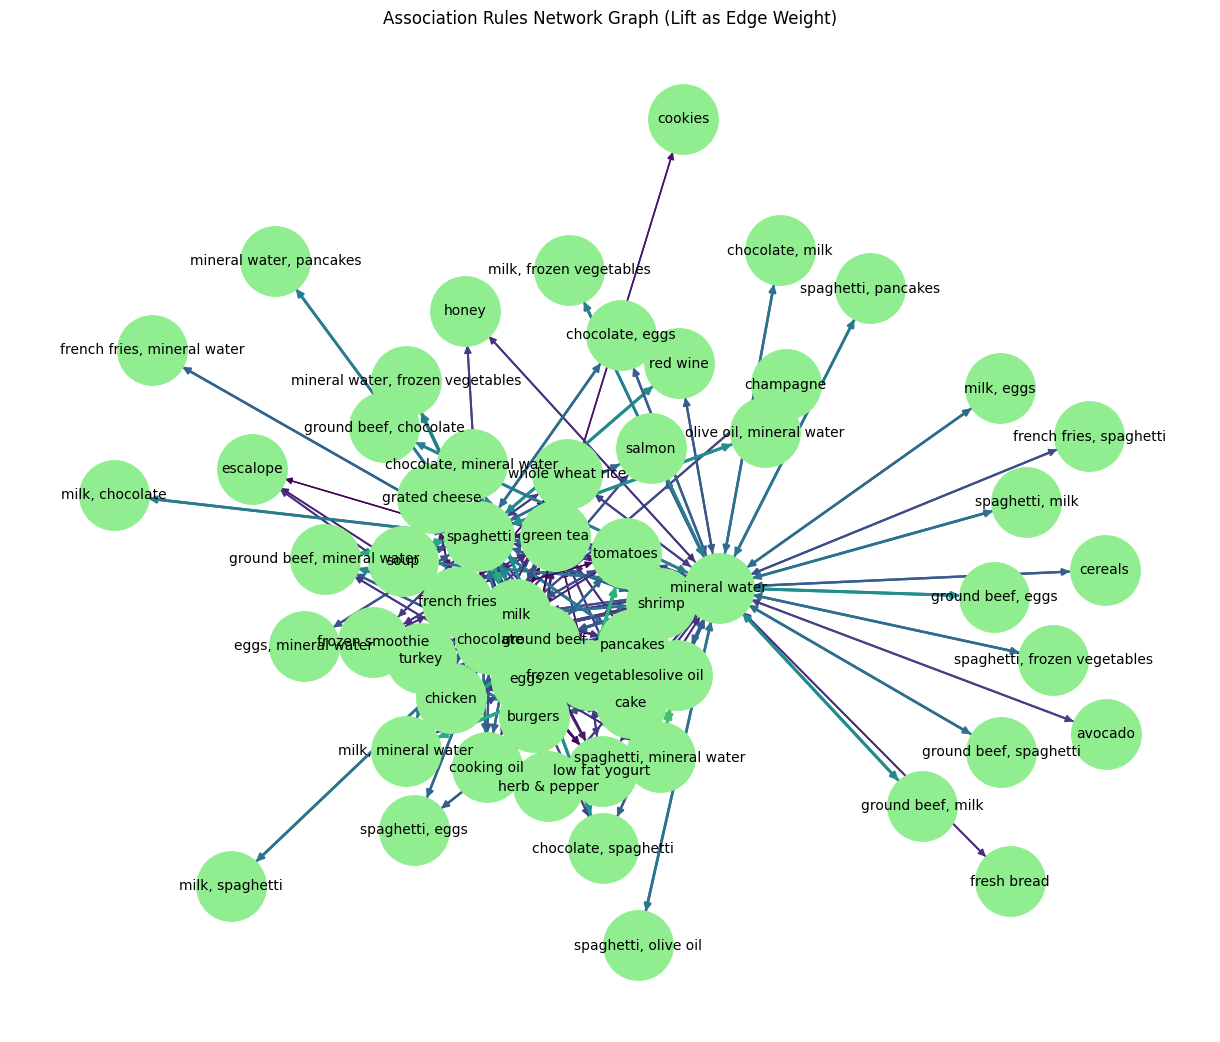

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

# Load dataset
df = pd.read_csv('MBA.csv', header=None)
transactions = df.apply(lambda row: row.dropna().tolist(), axis=1)

# Preprocess for one-hot encoding
all_items = sorted(set(item.strip() for trans in transactions for item in trans))
encoded_vals = []
for trans in transactions:
    row = {item: 0 for item in all_items}
    for item in trans:
        row[item.strip()] = 1
    encoded_vals.append(row)

df_encoded = pd.DataFrame(encoded_vals)

# Generate frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# ------------------------ HEATMAP ------------------------
pivot_table = rules.pivot_table(index='antecedents', columns='consequents', values='confidence', fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Confidence'})
plt.title('Heatmap of Confidence between Antecedents and Consequents')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --------------------- NETWORK GRAPH ---------------------
plt.figure(figsize=(12, 10))
G = nx.DiGraph()

# Add edges with lift as weight
for _, row in rules.iterrows():
    antecedent = ', '.join(list(row['antecedents']))
    consequent = ', '.join(list(row['consequents']))
    G.add_edge(antecedent, consequent, weight=row['lift'])

pos = nx.spring_layout(G, k=0.5, iterations=50)
edge_weights = [G[u][v]['weight'] for u,v in G.edges()]

nx.draw(G, pos, with_labels=True, node_size=2500, node_color='lightgreen', font_size=10,
        width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.viridis, arrows=True)
plt.title('Association Rules Network Graph (Lift as Edge Weight)')
plt.show()


1. Bar Graph – Top Frequent Itemsets by Support

C:\Users\shrin\AppData\Local\Temp\ipykernel_17336\656907936.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_itemsets, x='support', y='itemsets', palette='viridis')


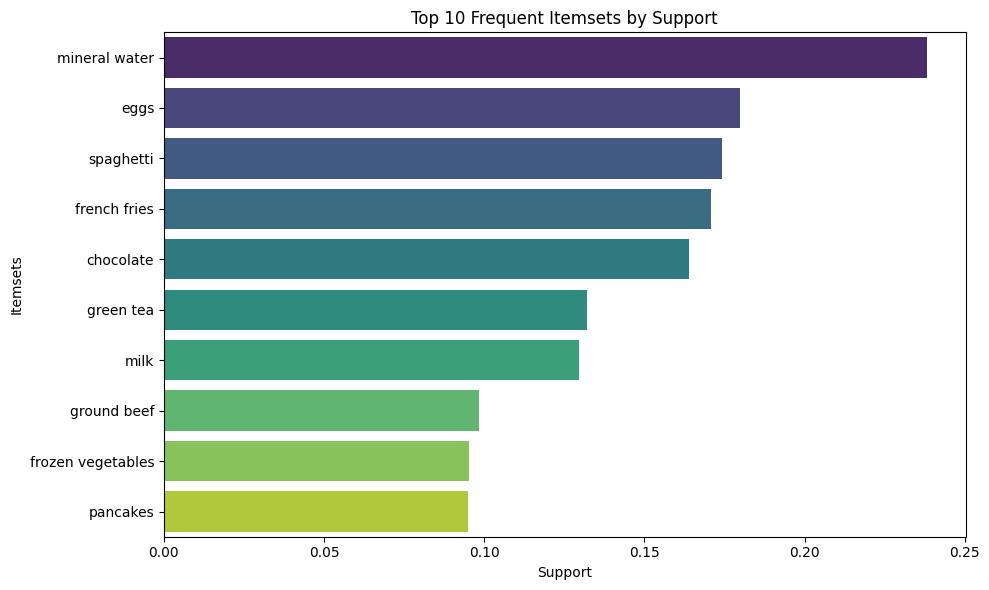

In [6]:
# --------------------- BAR PLOT: TOP ITEMSETS ---------------------
top_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(10)
top_itemsets['itemsets'] = top_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(10, 6))
sns.barplot(data=top_itemsets, x='support', y='itemsets', palette='viridis')
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.tight_layout()
plt.show()


2. Bar Graph – Top Association Rules by Lift

C:\Users\shrin\AppData\Local\Temp\ipykernel_17336\3399538050.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rules, x='lift', y='rule', palette='magma')


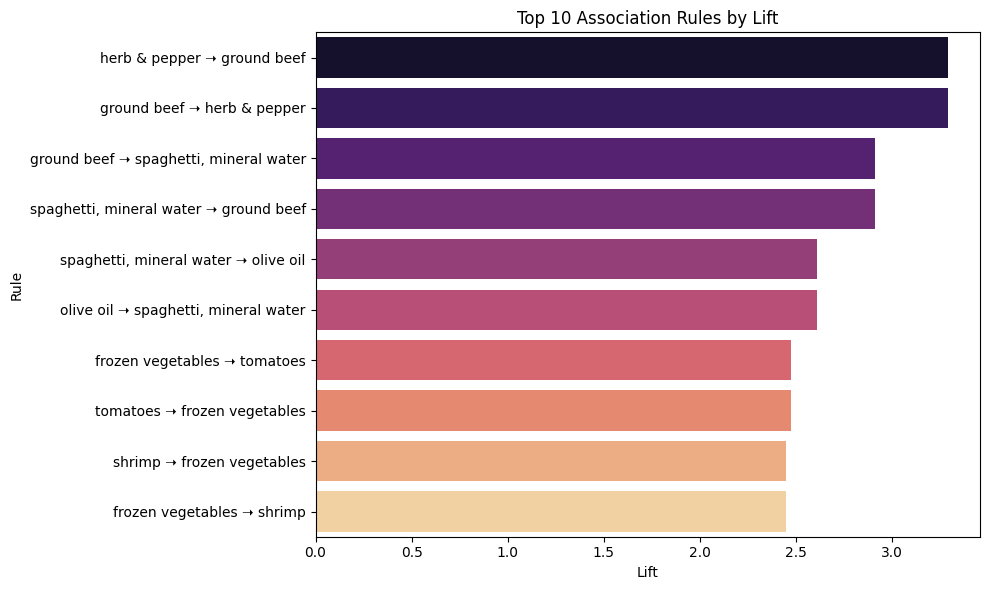

In [7]:
# --------------------- BAR PLOT: TOP RULES BY LIFT ---------------------
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
top_rules['rule'] = top_rules.apply(lambda row: f"{', '.join(list(row['antecedents']))} ➝ {', '.join(list(row['consequents']))}", axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_rules, x='lift', y='rule', palette='magma')
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Rule')
plt.tight_layout()
plt.show()


In [8]:
summary = rules[['support', 'confidence', 'lift', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'kulczynski']].describe()
print(summary)


          support  confidence        lift    leverage  conviction  \
count  406.000000  406.000000  406.000000  406.000000  406.000000   
mean     0.017154    0.183657    1.587598    0.005587    1.089712   
std      0.008308    0.103076    0.379892    0.003304    0.091367   
min      0.010132    0.042506    1.013557    0.000163    1.000973   
25%      0.011465    0.099265    1.306506    0.003615    1.028983   
50%      0.014398    0.168497    1.519657    0.005214    1.054913   
75%      0.019164    0.246304    1.811096    0.006738    1.121048   
max      0.059725    0.506667    3.291994    0.022088    1.543848   

       zhangs_metric     jaccard  kulczynski  
count     406.000000  406.000000  406.000000  
mean        0.381934    0.076557    0.183657  
std         0.164607    0.023642    0.042271  
min         0.014528    0.039604    0.115642  
25%         0.265999    0.060681    0.151111  
50%         0.395526    0.072240    0.177875  
75%         0.506973    0.086173    0.208854  
ma